# Sistema de Inteligência Artificial para Otimização de Estações de Carregamento de Veículos Elétricos

**Objetivo**: Desenvolver um sistema que prevê a necessidade de carregadores adicionais e otimiza a gestão de recursos energéticos para carregamento de veículos elétricos.



1. Importação de bibliotecas para manipulação de dados, visualização e criação de modelos

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from scipy.optimize import linprog
import re

Justificativa: Estas bibliotecas auxiliam na manipulação e visualização de dados, construção de modelos de previsão e otimização de recursos.

2. Carregamento e Exploração dos Dados


In [ ]:
# Carregando o dataset
file_path = '/content/Electric_Vehicle_Charging_Stations.csv'  # Caminho do arquivo
data = pd.read_csv(file_path)

# Exibindo uma amostra e informações do conjunto de dados
print(data.head())
print(data.info())

                          Station Name          Street Address          City  \
0                        BMW OF DARIEN        138-142 Ledge Rd        Darien   
1         Dunkin’ - Tesla Supercharger           893 E Main St       Meriden   
2  Town of Beacon Falls - Commuter Lot           105 N Main St  Beacon Falls   
3                      OLD SAYBROOK VW  319 Middlesex Turnpike  Old Saybrook   
4               Fairfield Rail Station        80 Mill Plain Rd     Fairfield   

                     Access Days Time EV Level1 EVSE Num EV Level2 EVSE Num  \
0                      24 hours daily               NONE                  2   
1  24 hours daily; for Tesla use only               NONE               NONE   
2                      24 hours daily               NONE                  1   
3                      24 hours daily               NONE                  2   
4                      24 hours daily               NONE                  2   

  EV DC Fast Count EV Other Info            

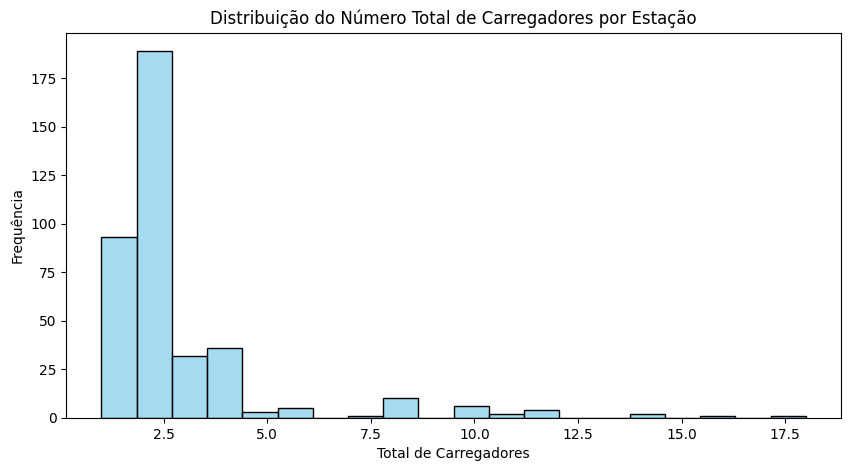

In [77]:
# Histograma do número total de carregadores em cada estação
plt.figure(figsize=(10, 5))
sns.histplot(data['total_chargers'], bins=20, color='skyblue')
plt.title("Distribuição do Número Total de Carregadores por Estação")
plt.xlabel("Total de Carregadores")
plt.ylabel("Frequência")
plt.show()

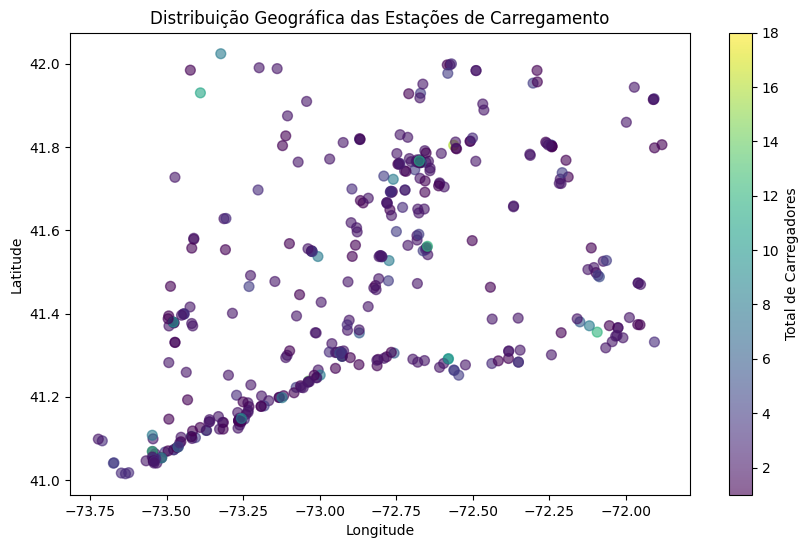

In [76]:
# Mapa de dispersão das estações
plt.figure(figsize=(10, 6))
plt.scatter(data['longitude'], data['latitude'], c=data['total_chargers'], cmap='viridis', s=50, alpha=0.6)
plt.colorbar(label='Total de Carregadores')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribuição Geográfica das Estações de Carregamento")
plt.show()


Justificativa: Compreender a estrutura inicial do conjunto de dados é fundamental para definir as variáveis de entrada e saída.

3. Pré-processamento e Engenharia de Features


In [68]:
# Extraindo coordenadas de 'New Georeferenced Column'
def extract_coordinates(geo_column):
    """Extrai latitude e longitude a partir da coluna georeferenciada."""
    coords = geo_column.apply(lambda x: re.findall(r"-?\d+\.\d+", str(x)))
    lat = coords.apply(lambda x: float(x[1]) if len(x) == 2 else np.nan)
    lon = coords.apply(lambda x: float(x[0]) if len(x) == 2 else np.nan)
    return lat, lon

data['latitude'], data['longitude'] = extract_coordinates(data['New Georeferenced Column'])

# Convertendo colunas de número de carregadores para numérico (substituindo "NONE" por 0)
data['EV Level1 EVSE Num'] = pd.to_numeric(data['EV Level1 EVSE Num'].replace("NONE", 0))
data['EV Level2 EVSE Num'] = pd.to_numeric(data['EV Level2 EVSE Num'].replace("NONE", 0))
data['EV DC Fast Count'] = pd.to_numeric(data['EV DC Fast Count'].replace("NONE", 0))
data['total_chargers'] = data['EV Level1 EVSE Num'] + data['EV Level2 EVSE Num'] + data['EV DC Fast Count']

# Simulando uma demanda baseada no total de carregadores
data['simulated_demand'] = data['total_chargers'] * np.random.uniform(1, 2, size=len(data))

# Selecionando variáveis para o modelo
X = data[['latitude', 'longitude', 'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count']].fillna(0)
y = data['simulated_demand']


Justificativa: A criação de variáveis geográficas e a soma do total de carregadores por estação permite que o modelo entenda a densidade e capacidade de cada estação.

4. Normalização e Divisão dos Dados


In [69]:
# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividindo em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Justificativa: A normalização ajuda a estabilizar o treinamento da rede neural, e a divisão dos dados em treino e teste permite avaliar a precisão do modelo.

5. Construção e Treinamento da Rede Neural para Previsão de Demanda


In [70]:
# Construindo uma rede neural densa com Keras para previsão de demanda
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Saída de um único valor
])

model.compile(optimizer='adam', loss='mse')

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2, verbose=1)

# Avaliação do modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Erro quadrático médio (MSE):", mse)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 30.6387 - val_loss: 26.0341
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.1089 - val_loss: 17.0541
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7836 - val_loss: 9.9474
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8585 - val_loss: 6.2401
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7490 - val_loss: 3.8282
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3281 - val_loss: 2.3260
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3415 - val_loss: 1.4497
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9391 - val_loss: 1.1422
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9061 - val_loss: 0.9347
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8078 - val_loss: 0.9000
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8216 - val_loss: 0.8158
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8517 - val_loss: 0.

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Erro quadrático médio (MSE): 2.2679124131364676


Justificativa: A rede neural densa captura padrões complexos nos dados, proporcionando previsões robustas para a demanda de energia das estações de carregamento.

6. Otimização de Recursos com Programação Linear


In [71]:
# Definindo o problema de otimização
demand_forecast = y_pred.flatten()  # Demandas previstas a partir do modelo
demand_forecast = np.maximum(demand_forecast, 0.1)  # Garante que os valores são positivos

# Parâmetros de otimização
max_capacity = 1000  # Capacidade máxima de energia disponível
cost_per_unit = 0.10  # Custo por unidade de energia

# Função objetivo: minimizar o custo total de energia
c = [cost_per_unit] * len(demand_forecast)

# Matriz de restrição para garantir que a alocação de energia não ultrapasse a demanda
A_ub = np.eye(len(demand_forecast))
b_ub = demand_forecast

# Definindo uma demanda mínima proporcional, 50% da demanda prevista
min_demand = 0.5 * demand_forecast  # Ajusta a demanda mínima como 50% da demanda prevista
bounds = [(min_d, max_capacity) for min_d in min_demand]

# Resolvendo o problema de programação linear com limites proporcionais à demanda
result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds)

# Verificando a alocação de energia otimizada e o custo total
if result.success:
    print("Alocação de energia otimizada:", result.x)
    print("Custo total de energia:", result.fun)
else:
    print("O problema de otimização não encontrou uma solução viável.")

# Justificativa: A programação linear minimiza o custo de energia, garantindo que a demanda seja atendida dentro dos limites de capacidade e demanda mínima.


Alocação de energia otimizada: [ 1.46565342  2.35689068  1.42276025  0.97592986  6.85488605  0.83722609
  5.0446353   0.80168635  1.50775397  1.42411184  4.22699785  4.89269972
  6.93989038  3.0003109   0.82809979  1.46583319  0.85119545  1.53484094
  0.81436759  8.46333885  1.51222849  1.57982445  0.93472111  6.82243586
  0.75663626  0.77016181  1.45127094  1.42831707  1.48494399  1.14934266
  1.46218204  0.75401074  2.35084772  2.30831218  1.6513449   2.55224562
  1.50445008  1.74841261  1.60695386  1.72841763  1.5306406   1.12884808
  1.82757509  1.43435609  3.25076628  0.72945118  0.76061159  1.45120049
  1.58747053  0.86421514  0.77658868  1.47028744  1.41487968  1.5240649
  0.76772851  1.50438023  0.84632164  1.56613231  1.47541332  3.27236557
  1.49534464  1.50237906  3.34116316  1.46724272  0.70695466  8.13591766
  3.36706686  0.81781125  8.36305046  1.421134   13.12931538  3.12665462
  1.60945249  1.44928002  3.41198373  1.5410881   3.09400582]
Custo total de energia: 17.84293

Justificativa: A programação linear minimiza o custo de energia, garantindo que a demanda seja atendida sem exceder a capacidade.

6. Comparação com Modelo de Regressão Linear

Erro Quadrático Médio (MSE) da Regressão Linear: 1.9397373485538771


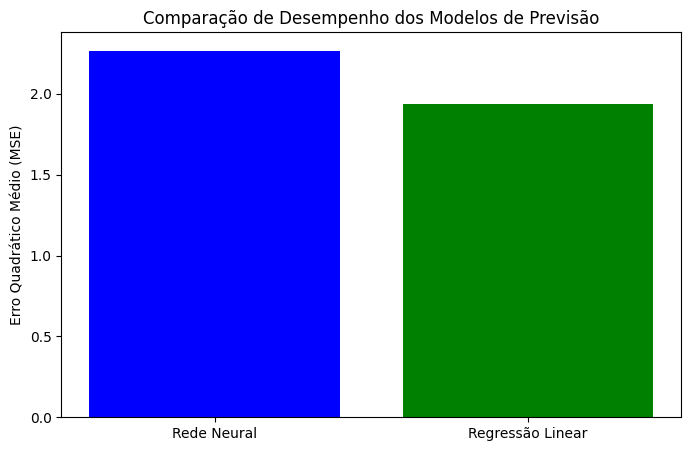

In [72]:
# Treinando um modelo de Regressão Linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Fazendo previsões com a Regressão Linear
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print("Erro Quadrático Médio (MSE) da Regressão Linear:", mse_linear)

# Comparação dos MSEs
mse_neural = mean_squared_error(y_test, y_pred)  # y_pred da rede neural

plt.figure(figsize=(8, 5))
plt.bar(['Rede Neural', 'Regressão Linear'], [mse_neural, mse_linear], color=['blue', 'green'])
plt.ylabel("Erro Quadrático Médio (MSE)")
plt.title("Comparação de Desempenho dos Modelos de Previsão")
plt.show()

# Visualização dos Resultados

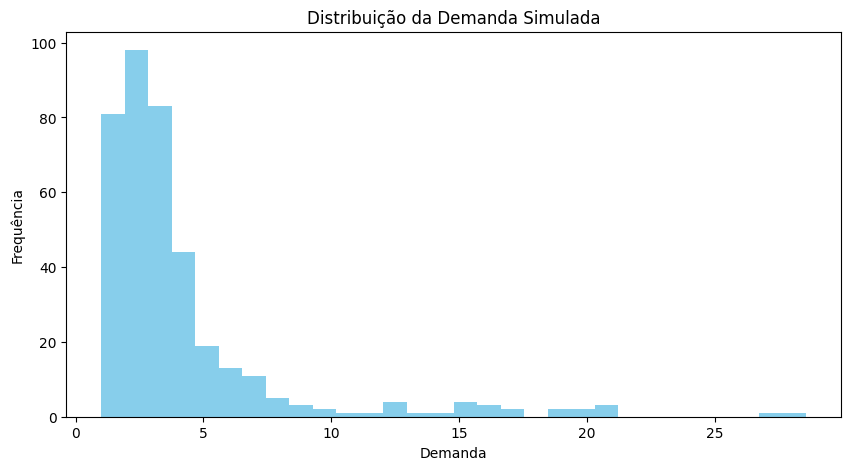

In [73]:
# Histograma da demanda simulada
plt.figure(figsize=(10, 5))
plt.hist(data['simulated_demand'], bins=30, color='skyblue')
plt.title("Distribuição da Demanda Simulada")
plt.xlabel("Demanda")
plt.ylabel("Frequência")
plt.show()

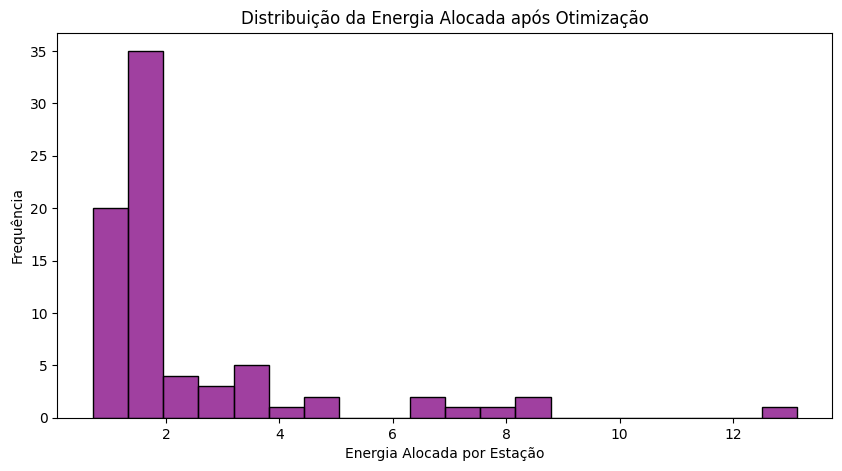

In [74]:
# Histograma da alocação de energia otimizada
plt.figure(figsize=(10, 5))
sns.histplot(result.x, bins=20, color='purple')
plt.title("Distribuição da Energia Alocada após Otimização")
plt.xlabel("Energia Alocada por Estação")
plt.ylabel("Frequência")
plt.show()

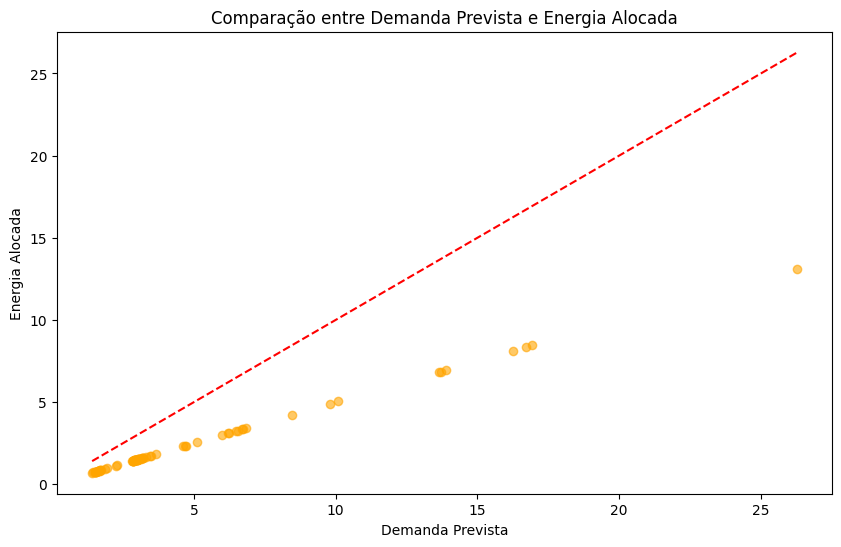

In [75]:
# Comparação da demanda prevista e da energia alocada
plt.figure(figsize=(10, 6))
plt.scatter(demand_forecast, result.x, alpha=0.6, color='orange')
plt.plot([min(demand_forecast), max(demand_forecast)], [min(demand_forecast), max(demand_forecast)], 'r--')
plt.xlabel("Demanda Prevista")
plt.ylabel("Energia Alocada")
plt.title("Comparação entre Demanda Prevista e Energia Alocada")
plt.show()

**Conclusão**: Este sistema de IA permite prever a demanda de energia para estações de carregamento de veículos elétricos, utilizando uma rede neural densa, e otimizar a alocação de recursos energéticos com programação linear. A abordagem minimiza o custo de energia ao mesmo tempo que atende às necessidades de demanda mínima e restrições de capacidade máxima.